# Persistent Homology

### MSRI-UP 2023

Authors: Jose Perea 

Date: 06/13/2023


---


In [1]:
import time
import numpy as np
from scipy.spatial import distance

#topological data analysis
from ripser import ripser
from persim import plot_diagrams

#plotting and visualization
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from matplotlib.patches import Circle

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Helper functions
 
def maxmin(dist_matrix, n):
    '''
    Given a distance matrix retunrs a maxmin subsampling and the covering radious 
    corresponding to the subsampled set.
    
    :param dist_matrix: Distance matrix
    :param n: Size of subsample set.
    :returns L: List of indices corresponding to the subsample set.
    :return cr: Covering radious for the subsample set.
    '''
    L = [np.random.randint(0,len(dist_matrix))]
    
    dist_to_L = dist_matrix[ L[-1] ,:]
    
    for i in range(n-1):
        ind = np.argmax( dist_to_L )
        L.append(ind)
        
        dist_to_L = np.minimum(dist_to_L, dist_matrix[L[-1], :])
        
    cr = np.max(dist_to_L)

    return L, cr

def uniform_sampling(dist_matrix, n):
    '''
    Given a distance matrix returns a subsampling that preserves the distribution of the original data set 
    and the covering radious corresponding to the subsampled set.
    
    :param dist_matrix: Distance matrix
    :param n: Size of subsample set.
    :returns L: List of indices corresponding to the subsample set.
    :return cr: Covering radious for the subsample set.
    '''
    num_points = dist_matrix.shape[0]
    
    L = np.random.choice(num_points, n)
    
    dist_to_L = np.min(dist_matrix[L,:], axis=0)
    
    return L, np.max(dist_to_L)

def plot_barcodes(diagrams, alpha_max, width = 1.5):
    max_dim = len(diagrams)
    fig, axs = plt.subplots(max_dim)
    fig.suptitle('Barcodes')
    for dim in range(max_dim):
        barcode = np.copy(diagrams[dim])
        ind_inf = np.isinf(barcode.T[1])
        barcode[ind_inf, 1] = alpha_max
        h = 1
        for i in range(len(barcode)):
            x = barcode[i]
            y = [h,h]
            axs[dim].plot(x, y, linestyle= '-', c='#1f77b4', linewidth = width)
            if ind_inf[i]:
                axs[dim].scatter([alpha_max],[h],  s=10, marker='>', c='#1f77b4')
            h += 1
        axs[dim].set_xlim(0, 1.05*alpha_max)
        axs[dim].set_ylim(0,h)
        axs[dim].get_yaxis().set_ticks([]);
        axs[dim].spines['right'].set_color('none')
        axs[dim].spines['top'].set_color('none')
        axs[dim].text(0.3,1,'$\mathrm{bcd}^{\mathcal{R}}_{'+str(dim)+'}(X)$', verticalalignment='bottom')

---

### Toy example dataset

In [48]:
np.random.seed(1223)

n_data = 30
theta = np.random.uniform(0, 2*np.pi, n_data)
data = np.array([np.cos(theta) , np.sin(theta) , np.zeros_like(theta)])
data += np.random.normal(0, 0.08, data.shape)

fig = go.Figure(data=[go.Scatter3d(
    x=data[0], y=data[1], z=data[2], 
    mode ='markers', 
    marker=dict(size = 3 , color = 'grey'))])

fig.update_layout(scene= dict(zaxis = dict(range=[-1, 1])))
fig.show()

### Rips Filtration

Given a dataset $(X,\mathbf{d}_X)$, its Rips filtration is defined as:

$$\mathcal{R}(X) = \Big\{\, i_{\alpha',\alpha}: R_\alpha(X) \hookrightarrow R_{\alpha'} (X)\, \Big\}_{0 < \alpha\leq \alpha'} $$
where
$$R_\alpha(X) = \Big\{\, \sigma \subset X \mid 0 < \#(\sigma) < \infty \;\mbox{ and }\; \mathsf{diam}(\sigma) < \alpha\, \Big\} $$

**Do:** Use the cell below to visualize the Rips complex of the provided dataset at various distance (filtration) thresholds.

In [49]:
alpha = 10
distMat = distance.squareform(distance.pdist(data.T))

ii = []; jj = []; kk = []
e_x =[]; e_y =[]; e_z =[]

for i in range(n_data):
    for j in range(i+1,n_data):
        if distMat[i,j] < alpha:
            # add edge (i,j)
            e_x.extend([data[0,i], data[0,j], None])
            e_y.extend([data[1,i], data[1,j], None])
            e_z.extend([data[2,i], data[2,j], None])
            
            for k in range(j+1,n_data):
                if np.max([distMat[j,k], distMat[i,k]]) < alpha:
                    # add triangle (i,j,k)
                    ii.append(i); jj.append(j); kk.append(k)
                
vertices = go.Scatter3d(mode = 'markers', name = 'vertices', 
                        x = data[0], y = data[1],  z = data[2], 
                        marker=dict(size = 3 , color = 'grey'))

edges = go.Scatter3d(mode='lines', name = 'edges', 
                     x=e_x, y=e_y, z=e_z, 
                     line=dict(color= 'rgb(70,70,70)', width=1))  

triangles = go.Mesh3d(x=data[0], y=data[1], z=data[2],  i = ii, j = jj, k = kk,  color='lightpink', opacity=0.2)

fig = go.Figure(data=[vertices, edges, triangles])
fig.update_traces(hoverinfo="none")
fig.update_layout(scene= dict(
                      xaxis = dict(showspikes=False), 
                      yaxis = dict(showspikes=False), 
                      zaxis = dict(showspikes=False,range=[-1, 1])))
fig.show()

**Question:** At what filtration scale is the circle created? At what scale is it filled in? 

**Youranswer:**
0.9
---

### Computing Persistence via Ripser

U. Bauer: "Ripser is a lean C++ code for the computation of Vietoris–Rips persistence barcodes. It can do just this one thing, but does it extremely well."

Original C++ library : https://github.com/Ripser/ripser

Accompanying paper : https://arxiv.org/pdf/1908.02518.pdf

Python library: https://ripser.scikit-tda.org/en/latest


--- 0.0009710788726806641 seconds ---


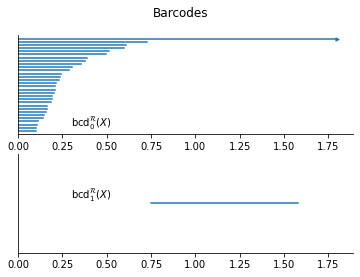

In [50]:
# Persistence Computation
start_time = time.time()
rips_persistence = ripser(data.T, maxdim=1)
print("--- %s seconds ---" % (time.time() - start_time))

dgms = rips_persistence['dgms']
plot_barcodes(dgms,1.8);

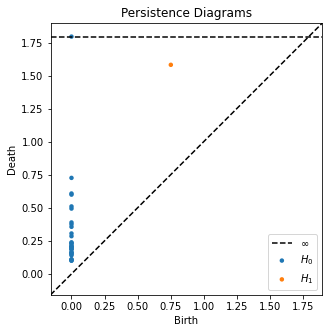

In [51]:
plt.figure(figsize = (5,5)) 
plot_diagrams(dgms, title='Persistence Diagrams')

### Persistence is stable with respect to Hausdorff Noise

**Theorem** (Stability): Let $(\mathbb{M}, d_\mathbb{M})$ be a metric space and let $X,Y \subset \mathbb{M}$. Then for all $j > 0$ and every field $\mathbb{F}$, 

$$ d_B\left(\mathsf{dgm}_j^\mathcal{R}(X; \mathbb{F}) , \mathsf{dgm}_j^\mathcal{R}(Y; \mathbb{F})\right) \leq 2 d_H^\mathbb{M}(X,Y) $$ 

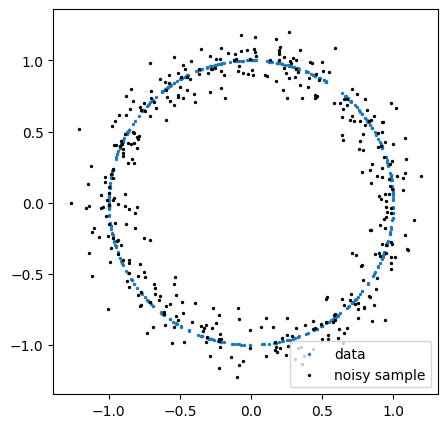

In [52]:
np.random.seed(2)

# Generate angles uniformly between 0 and 2pi
n_data = 400
theta = np.random.uniform(0, 2*np.pi, n_data)

# Generate radii with Gaussian noise centered at 1 and variance sigma
sigma = 0.1
r = np.random.normal(1, sigma , n_data)
X = np.array([ np.cos(theta) , np.sin(theta)]) 
Y = r*X
X = X.T
Y = Y.T

plt.figure(figsize = (5,5)) 
plt.scatter(X[:,0], X[:,1], s = 2 , label = 'data');
plt.scatter(Y[:,0], Y[:,1], s = 2, c='black' , label = 'noisy sample');
plt.legend(loc = 'lower right')
plt.axis('square');

In [53]:
# Hausdorff distance

d_XY =  np.max(np.min(distance.cdist(X,Y), axis = 0))
d_YX =  np.max(np.min(distance.cdist(X,Y), axis = 1))

print( 'd_H(X,Y) = ',np.max( [d_XY, d_YX])  )

d_H(X,Y) =  0.31609659695458836


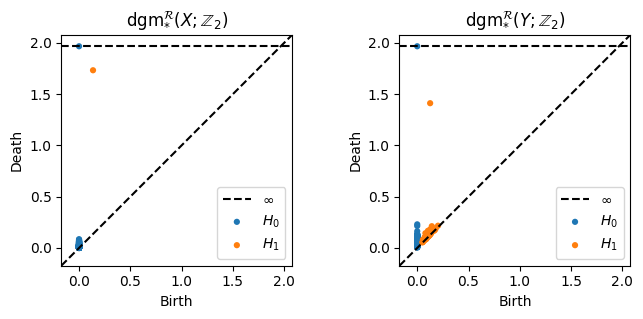

In [54]:
q = 2
 
PH_X = ripser(X, coeff=q )
PH_Y = ripser(Y, coeff=q )

plt.figure(figsize = (8,3)) 
plt.subplot(1,2,1)
plot_diagrams(PH_X['dgms'])
x_left, x_right = plt.xlim()
y_left, y_right = plt.ylim()
plt.title('$\mathsf{dgm}^\mathcal{R}_{*}(X; \mathbb{Z}_{' + str(q) +'})$');

plt.subplot(1,2,2)
plot_diagrams(PH_Y['dgms'],  xy_range  = [x_left, x_right, y_left, y_right] )
plt.title('$\mathsf{dgm}^\mathcal{R}_{*}(Y; \mathbb{Z}_{' + str(q) +'})$');

plt.show()
 

## Sampling is a good idea

If the dataset $(X,\mathbf{d}_X)$  is too large -- that is, if $N = \#(X)>>1$ -- then the persistence computation can be very slow. We will explore two strategies to get around this:  

#### Uniform  subsample:

Having indexed the points of $X$ arbitrarily as $X = \{x_1, \ldots, x_N\}$, choose indices $\{n_1, \ldots , n_k\} \subset \{1,\ldots, N\}$ uniformly at random (without replacement). Let $\tilde{X} = \{x_{n_1}, \ldots, x_{n_k}\} \subset X$ be the subsample.


#### MaxMin sampling:

Choose $x_1 \in X$ uniformly at random, and given $x_1,\ldots, x_{j} \in X$, let 
$$
x_{j+1} = \underset{x \in X}{\mathsf{argmax}} \,  \mathsf{min} \Big\{ \mathbf{d}_X(x_1, x) ,\ldots, \mathbf{d}_X(x_j, x)\Big\}
$$
stopping after $k$ iterations yields the subsample $\tilde{X} = \{x_1,\ldots, x_k\}$.

The stability theorem  implies that these are good ideas: If $X$ and $\tilde{X}$ are close in Hausdorff distance, then their diagrams will be close in Bottleneck distance. 

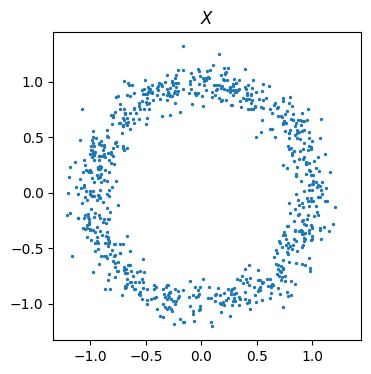

In [55]:
# Generate data around the unit circle
np.random.seed(2)

# Generate angles uniformly between 0 and 2pi
n_data = 800
theta = np.random.uniform(0, 2*np.pi, n_data)

# Generate radii with Gaussian noise centered at 1 and variance sigma
sigma = 0.1
r = np.random.normal(1, sigma , n_data)

X = r*np.array([ np.cos(theta) , np.sin(theta)]) 
X = X.T

# Plot data set X
plt.figure(figsize = (4,4))
plt.scatter(X[:,0], X[:,1], s = 2 );
plt.title('$X$')
plt.axis('square');

**Uniform sample**:

d_H(X,Y) = 0.40263363688906467


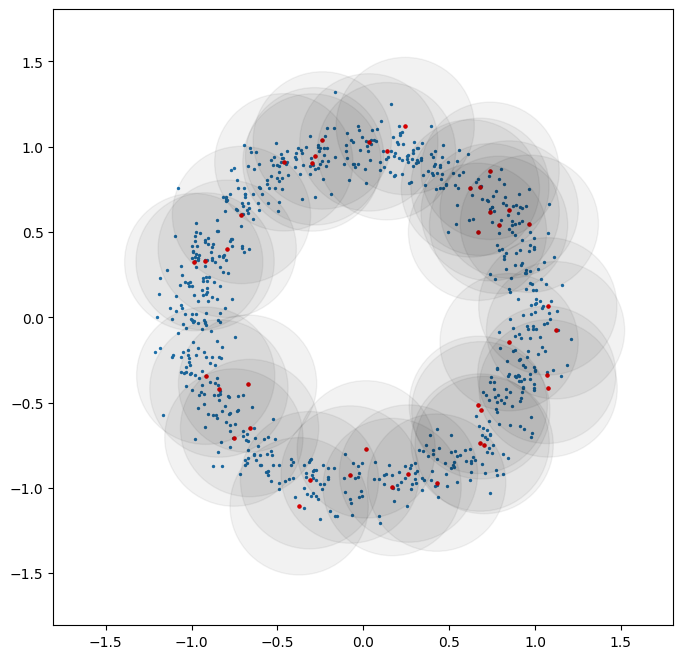

In [56]:
# Compute the distance matrix for the data set X using auclidean distance.
dm_X = distance.cdist(X,X)

# Subsample the data using uniform sampling
np.random.seed(2) # Comment out to get different samples
n_landmarks = 40 # number of points in uniform sample

ind_Y, cover_r = uniform_sampling(dm_X, n_landmarks)
Y = X[ind_Y]

# scatter plot the landmark subset
fig, ax = plt.subplots(figsize = (8,8))
plt.scatter(X.T[0], X.T[1], s = 2)
plt.scatter(Y.T[0], Y.T[1], s = 5, c='red')

# Plot balls or radious defined by the covering radious of the landmark set
for i in range(n_landmarks):
    cir = Circle((Y[i,0], Y[i,1]), cover_r, color=(0,0,0,0.05))
    ax.add_patch(cir)
ax.set_ylim(-1-2*cover_r,1+2*cover_r);
ax.set_xlim(-1-2*cover_r,1+2*cover_r);

r_Y = cover_r
print('d_H(X,Y) =',  r_Y)

In [57]:
q = 2

start_time = time.time()
PH_X = ripser(X, coeff=q )
X_time = time.time() - start_time

start_time = time.time()
PH_Y = ripser(Y, coeff=q )
Y_time = time.time() - start_time
print("--- PH_X_time = %s seconds ---" % (X_time))
print("--- PH_Y_time = %s seconds ---" % (Y_time))


--- PH_X_time = 2.3927431106567383 seconds ---
--- PH_Y_time = 0.0036859512329101562 seconds ---


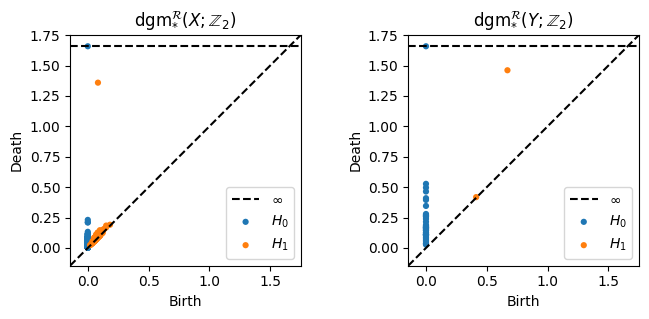

In [58]:
plt.figure(figsize = (8,3)) 
plt.subplot(1,2,2)
plot_diagrams(PH_Y['dgms'])
plt.title('$\mathsf{dgm}^\mathcal{R}_{*}(Y; \mathbb{Z}_{' + str(q) +'})$');
x_left, x_right = plt.xlim()
y_left, y_right = plt.ylim()

plt.subplot(1,2,1)
plot_diagrams(PH_X['dgms'], xy_range  = [x_left, x_right, y_left, y_right] )
plt.title('$\mathsf{dgm}^\mathcal{R}_{*}(X; \mathbb{Z}_{' + str(q) +'})$');
plt.show()

**Maxmin sampling:**

Distance from data to uniform sample, d_H(X,Y) = 0.40263363688906467
Distance from data to maxmin sample, d_H(X,M) = 0.2568335944409447


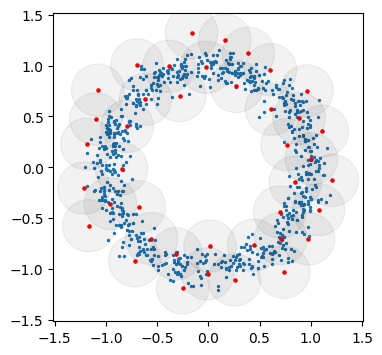

In [59]:
# Subsample the data using MaxMin sampling
np.random.seed(2) # Comment out to get different samples
ind_M, cover_r = maxmin(dm_X, n_landmarks)
M = X[ind_M]

# scatter plot the landmark subset
fig, ax = plt.subplots(figsize = (4,4))
plt.scatter(X.T[0], X.T[1], s = 2)
plt.scatter(M.T[0], M.T[1], s = 5, c='red')

# Plot balls or radious defined by the covering radious of the landmark set
for i in range(n_landmarks):
    cir = Circle((M[i,0], M[i,1]), cover_r, color=(0,0,0,0.05))
    ax.add_patch(cir)
ax.set_ylim(-1-2*cover_r,1+2*cover_r);
ax.set_xlim(-1-2*cover_r,1+2*cover_r);

print('Distance from data to uniform sample, d_H(X,Y) =', r_Y)
print('Distance from data to maxmin sample, d_H(X,M) =',  cover_r)

In [60]:
q = 2
start_time = time.time()
PH_M= ripser(M, coeff=q )
print("--- %s seconds ---" % (time.time() - start_time))


--- 0.0028426647186279297 seconds ---


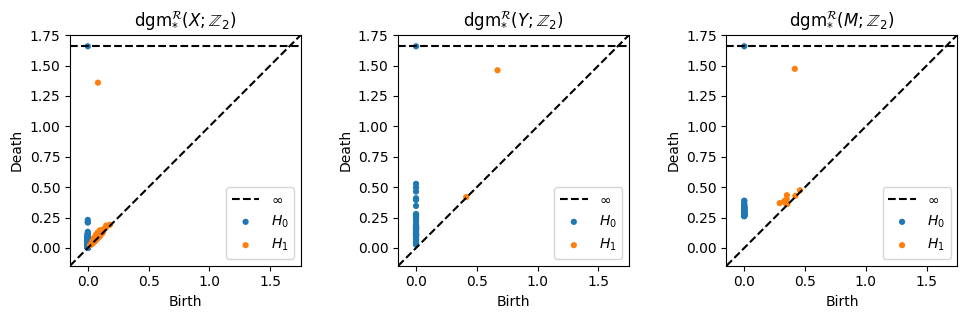

In [61]:
plt.figure(figsize = (12,3)) 
plt.subplot(1,3,2)
plot_diagrams(PH_Y['dgms'])
plt.title('$\mathsf{dgm}^\mathcal{R}_{*}(Y; \mathbb{Z}_{' + str(q) +'})$');
x_left, x_right = plt.xlim()
y_left, y_right = plt.ylim()

plt.subplot(1,3,1)
plot_diagrams(PH_X['dgms'], xy_range  = [x_left, x_right, y_left, y_right] )
plt.title('$\mathsf{dgm}^\mathcal{R}_{*}(X; \mathbb{Z}_{' + str(q) +'})$');

plt.subplot(1,3,3)
plot_diagrams(PH_M['dgms'], xy_range  = [x_left, x_right, y_left, y_right] )
plt.title('$\mathsf{dgm}^\mathcal{R}_{*}(M; \mathbb{Z}_{' + str(q) +'})$');
plt.show()

---

## Activity: 

The goal of this experiment is to explore the effect that data size has on the computation time of persistent homology.

1. Select subsamples of different sizes, say from 5 to 500 in increments of 5.
2. Compute persistent homology for each subsample set generated, and compute the time ripser takes to compute persistent homology in each case.  
3. Plot sample size vs time and explain the effect the sample size has on the computation time.

In [20]:
# Generate data around the unit circle
np.random.seed(7)

# Generate angles uniformly between 0 and 2pi
n_data = 1000
theta = np.random.uniform(0, 2*np.pi, n_data)

# Generate radii with Gaussian noise centered at 1 and variance sigma
sigma = 0.1
r = np.random.normal(1, sigma , n_data)

#NAME OF THE DATA SET
X = r*np.array([ np.cos(theta) , np.sin(theta)]) 
X = X.T


In [23]:
X.shape

(1000, 2)

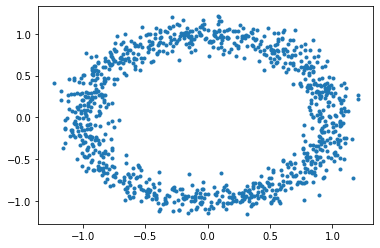

In [25]:
plt.plot(X[:,0], X[:,1], '.')

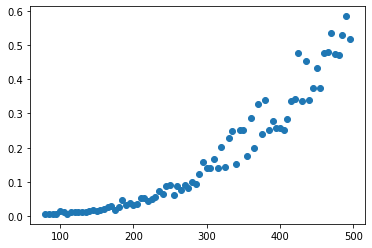

In [26]:
# Your answer here
#first create subsamples
time_output = []
size = np.arange(80, 500, 5)

ind_Y, cover_r = uniform_sampling(X, n_land)

#uniform sampling method:


for x in size:
    n_land = x
    ind_Y, cover_r = uniform_sampling(X, n_land)
    Y = X[ind_Y]

# Plot data set X
#plt.figure(figsize = (4,4))
#plt.scatter(X[:,0], X[:,1], s = 2 );
#plt.title('$X$')
#plt.axis('square');

#persistance homology computation

    start_time = time.time()
    comp = ripser(Y, coeff=2, n_perm = n_land)
    time_output.append(time.time() - start_time)
    #print("--- %s seconds ---" %(time.time() - start_time))

#plotting data

plt.scatter(size, time_output)

# print(n_land)
# print(ind_Y)
# print(X[ind_Y])

---

### Hausdorff vs Non-Hausdorff Noise

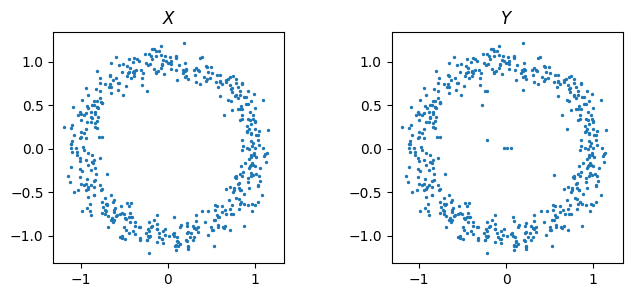

In [63]:
n_noise = 10
np.random.seed(2)
theta = np.random.uniform(0, 2*np.pi, n_noise)

# Generate radii with Gaussian noise centered at 1 and variance sigma
r = np.random.uniform(-1, 1 , n_noise)

D = r*np.array([ np.cos(theta) , np.sin(theta)]) 
D = D.T

Y = np.vstack((X,D))

# Plot data set X

plt.figure(figsize = (8,3)) 
plt.subplot(1,2,1)
plt.scatter(X[:,0], X[:,1], s = 2 );
plt.title('$X$')
plt.axis('square');

plt.subplot(1,2,2)
plt.scatter(Y[:,0], Y[:,1], s = 2 );
plt.title('$Y$')
plt.axis('square');


In [64]:
# Hausdorff distance

d_XY =  np.max(np.min(distance.cdist(X,Y), axis = 0))
d_YX =  np.max(np.min(distance.cdist(X,Y), axis = 1))

print( 'd_H(X,Y) = ',np.max( [d_XY, d_YX])  )

d_H(X,Y) =  0.6965474215365914


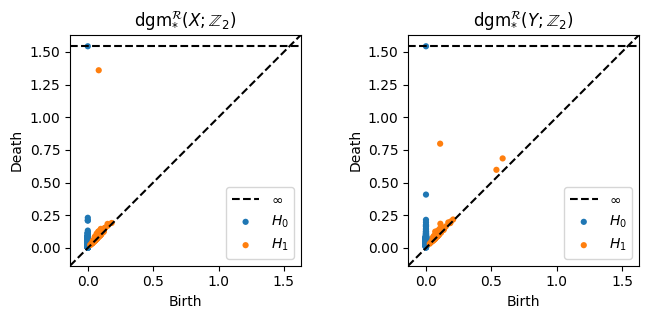

In [65]:
#Persistence computation
PH_Y = ripser(Y, coeff=q )

plt.figure(figsize = (8,3)) 
plt.subplot(1,2,1)
plot_diagrams(PH_X['dgms'])
x_left, x_right = plt.xlim()
y_left, y_right = plt.ylim()
plt.title('$\mathsf{dgm}^\mathcal{R}_{*}(X; \mathbb{Z}_{' + str(q) +'})$');

plt.subplot(1,2,2)
plot_diagrams(PH_Y['dgms'],  xy_range  = [x_left, x_right, y_left, y_right] )
plt.title('$\mathsf{dgm}^\mathcal{R}_{*}(Y; \mathbb{Z}_{' + str(q) +'})$');

plt.show()
 

---

**Question:** Is persistence stable with respect to outliers (non-Hausdorff noise)? 

**Your answer:**

---

### Data Example: Trefoil Knot

In [66]:
# Setup trefoil knot data
np.random.seed(1122)
n_data = 5000

u = 4*np.pi*np.random.rand(n_data)
v = 2*np.pi*np.random.rand(n_data)
data = np.zeros((3,n_data))

data[0] = np.cos(u)*np.cos(v) + 6*np.cos(u)*(1.5+np.sin(1.5*u)/2)
data[1] = np.sin(u)*np.cos(v) + 6*np.sin(u)*(1.5+np.sin(1.5*u)/2)
data[2] = np.sin(v) + 4*np.cos(1.5*u)
data += 0.2*np.random.randn(*data.shape)

# Plot the data 
fig = go.Figure(data=[go.Scatter3d(
    x=data[0], y=data[1], z=data[2], 
    mode ='markers', 
    marker=dict(size = 1.5 , color = 'grey'))])

fig.update_layout( width=900, height=450)
fig.show()

--- 0.29666996002197266 seconds ---


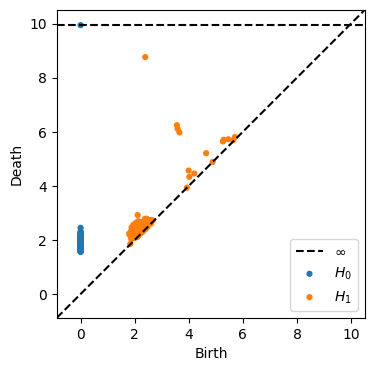

In [67]:
# Persistence Computation
start_time = time.time()
n_landmarks = 200 # number of landmarks to choose using maxmin sampling
prime_coeff = 7

rips_persistence = ripser(data.T, n_perm = n_landmarks, coeff = prime_coeff, maxdim=1)
print("--- %s seconds ---" % (time.time() - start_time))
dgms = rips_persistence['dgms']
idx_perm = rips_persistence['idx_perm']
plt.figure(figsize = (4,4)) 
plot_diagrams(dgms)

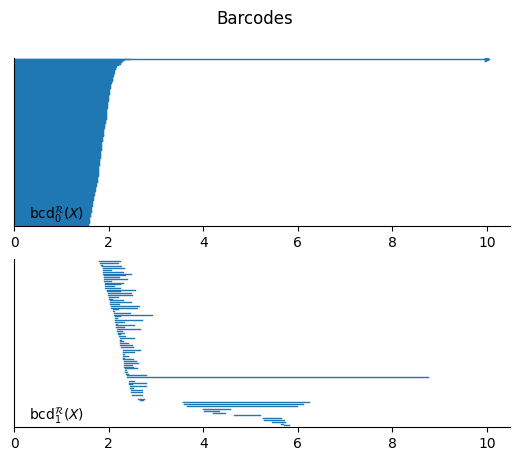

In [68]:
plot_barcodes(dgms, 10, 1)

**Note:** When there are too many intervals, the barcode is not that useful a visualization.

### Data Example: Torus

In [69]:
np.random.seed(2)
n_data = 25000
R = 5
r = 2
data = np.zeros((3, n_data))
s = np.random.rand(n_data)*2*np.pi
t = np.random.rand(n_data)*2*np.pi

data[0] = (R + r*np.cos(s))*np.cos(t)
data[1] = (R + r*np.cos(s))*np.sin(t)
data[2] = r*np.sin(s)
data += 0.1*np.random.randn(*data.shape)

# Plot the data 
fig = go.Figure(data=[go.Scatter3d(
    x=data[0], y=data[1], z=data[2], 
    mode ='markers', 
    marker=dict(size = 1.5 , color = 'grey'))])

fig.update_layout( width=900, height=450)
fig.show()

--- 0.923724889755249 seconds ---


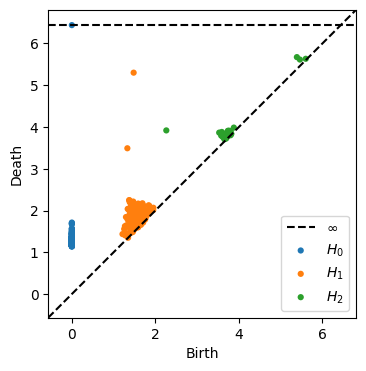

In [70]:
# Persistence Computation

# Persistence Computation
start_time = time.time()
n_landmarks = 200
prime_coeff = 7

rips_persistence = ripser(data.T, n_perm = n_landmarks, coeff = prime_coeff, maxdim=2)
print("--- %s seconds ---" % (time.time() - start_time))
dgms = rips_persistence['dgms']
idx_perm = rips_persistence['idx_perm']
plt.figure(figsize = (4,4)) 
plot_diagrams(dgms)

---

## Activity: 

1. Load the mistery data sets
2. Compute their persistent homology
3. Given the results, what topoloical spaces could they be sampling?

--- 1.0941941738128662 seconds ---


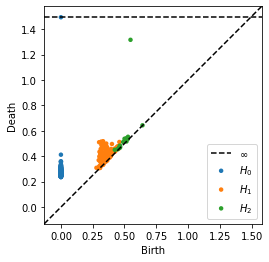

In [86]:
# Your answers here
import os

base_path = "data/"
filename = "Data_1.txt"
path_to_file = os.path.join(base_path, filename)
fd = open(path_to_file , 'r')

data_1 = np.genfromtxt(fd, dtype = float , delimiter=' ')

trans_data_1 = np.transpose(data_1)

# Plot the data 
fig = go.Figure(data=[go.Scatter3d(
    x=trans_data_1[0], y=trans_data_1[1], z=trans_data_1[2], 
    mode ='markers', 
    marker=dict(size = 1.5 , color = 'grey'))])
fig.update_layout( width=900, height=450)
fig.show()


# Persistence Computation
start_time = time.time()
n_landmarks = 200
prime_coeff = 7

rips_persistence = ripser(trans_data_1.T, n_perm = n_landmarks, coeff = prime_coeff, maxdim=2)
print("--- %s seconds ---" % (time.time() - start_time))
dgms = rips_persistence['dgms']
idx_perm = rips_persistence['idx_perm']
plt.figure(figsize = (4,4)) 
plot_diagrams(dgms)


SyntaxError: leading zeros in decimal integer literals are not permitted; use an 0o prefix for octal integers (<ipython-input-54-d2d1f6a27ca4>, line 1)